# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


%cd /home/jovyan/ASMSA/mydev

import os, sys

repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

# 3. Fai l’import “pulito”
from utils import split_dataset, callbacks, plot_latent_space, process_trajectory
from vae import build_asmsa_beta_vae


2025-08-01 10:49:50.030550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 10:49:50.046913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 10:49:50.051840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 10:49:50.067618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 10:49:50.877889: W tensorflow/compiler/tf2

/home/jovyan/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x7ec5ec7b3f40>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
bb_indices, n_bb, features_normalized, scaler, coords = process_trajectory(tr, conf)
features_normalized.shape

(50001, 366)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all = split_dataset(features_normalized, train_size=70, val_size=15, batch_size=64, seed=42)

2025-08-01 10:49:58.521481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8075 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


Dataset Statistics:
  Train: 35000 samples, 546 batches
  Val:   7500 samples, 118 batches
  Test:  7501 samples, 118 batches
  Batch size: 64


# VAE

In [6]:
'''
Batch Norm, nel caso, va prima della layer activation)
'''

'\nBatch Norm, nel caso, va prima della layer activation)\n'

In [10]:
latent_dim = 2
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_loss")

learning_rate = 1e-4

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-5, 
    beta_1=0.9,
    beta_2=0.999
)

# Creazione modello con beta migliorato
beta_vae, encoder, decoder = build_asmsa_beta_vae(
    n_features=features_normalized.shape[1], 
    latent_dim=latent_dim,
    beta=0.001 
)

# Compilazione
beta_vae.compile(optimizer=optimizer)

In [11]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)

Epoch 1/500


I0000 00:00:1754045501.594703  210120 service.cc:146] XLA service 0x7ec16001b8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754045501.594783  210120 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2025-08-01 10:51:41.767491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-01 10:51:42.368722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 20/546 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 4.0653e-04 - loss: 0.0953 - reconstruction_loss: 0.0949     

I0000 00:00:1754045509.300509  210120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


538/546 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0010 - loss: 0.0872 - reconstruction_loss: 0.0862    
Epoch 1: val_loss improved from inf to 0.06982, saving model to best_beta_vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - kl_loss: 0.0010 - loss: 0.0871 - reconstruction_loss: 0.0860 - val_kl_loss: 0.0014 - val_loss: 0.0698 - val_reconstruction_loss: 0.0684 - learning_rate: 1.0000e-04
Epoch 2/500


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0014 - loss: 0.0691 - reconstruction_loss: 0.0677
Epoch 2: val_loss improved from 0.06982 to 0.06804, saving model to best_beta_vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 0.0014 - loss: 0.0691 - reconstruction_loss: 0.0677 - val_kl_loss: 0.0012 - val_loss: 0.0680 - val_reconstruction_loss: 0.0669 - learning_rate: 1.0000e-04
Epoch 3/500
535/546 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0011 - loss: 0.0676 - reconstruction_loss: 0.0665
Epoch 3: val_loss improved from 0.06804 to 0.06720, saving model to best_beta_vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 0.0011 - loss: 0.0676 - reconstruction_loss: 0.0665 - val_kl_loss: 0.0011 - val_loss: 0.0672 - val_reconstruction_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 4/500
542/546 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - kl_loss: 0.0011 - loss: 0.0670 - reconstruction_loss: 0.0658
Epoch 4: val_loss improved from 0.06720 to 0.06673, saving model to 

tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [12]:
'''
from tensorflow.keras.models import load_model

autoencoder = load_model(f'best_beta_vae_2d.keras')
encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")
'''

'\nfrom tensorflow.keras.models import load_model\n\nautoencoder = load_model(f\'best_beta_vae_2d.keras\')\nencoder = autoencoder.get_layer("encoder")\ndecoder = autoencoder.get_layer("decoder")\n'

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


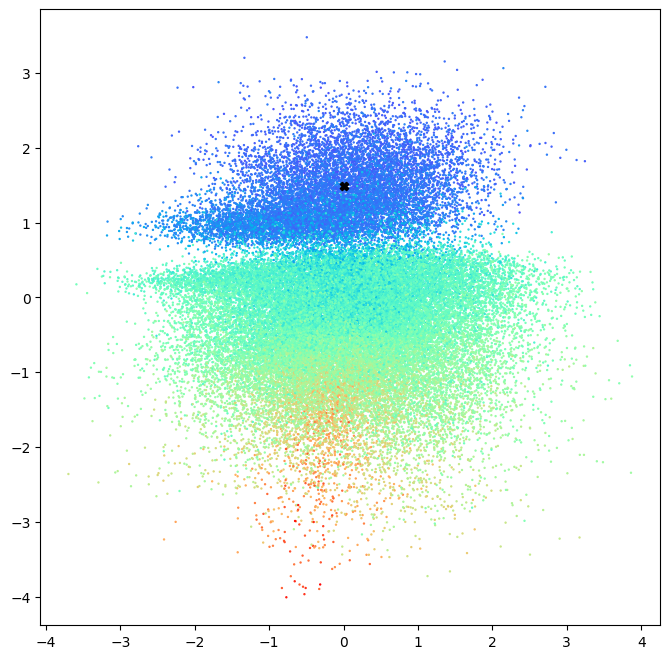

In [18]:
target = np.array([0,1.5]).reshape(1, latent_dim)
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, target, bb_indices, model="vae")

In [19]:
emb.shape

rms_ref = md.load_pdb(conf)
rms_ref_bb   = rms_ref.atom_slice(bb_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [20]:
from sklearn.preprocessing import MinMaxScaler

s = decoder.predict(sample)
s_orig = scaler.inverse_transform(s)

coords_flat = s_orig[0, :coords.shape[1]]                    
coords_recons = coords_flat.reshape((n_bb, 3))

new_traj = md.Trajectory(
    xyz=np.array([coords_recons]),     
    topology=rms_ref_bb.topology     
)


new_traj.save_pdb("reconstructed.pdb")
view = nv.show_file('reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


NGLWidget()